In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pickle as pickle # for saving loss objects

import dataset as dd # custom dataset class
import models as md

# so that when you change an imported file, it changes in the notebook
%load_ext autoreload 
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
model_params_1 = [{'tag': 'pooling_channel_aug_small', 'legend' : 'Pooling with Channel Augmentation', 
                   'use_pool': True, 'do_channel_augmentation': True, 'model_fn': md.get_unet},
                {'tag': 'no_pooling_channel_aug_small', 'legend' : 'No Pooling with Channel Augmentation', 
                 'use_pool': False, 'do_channel_augmentation': True, 'model_fn': md.get_unet}]

model_params_2 = [{'tag': 'pooling_no_channel_aug_small', 'legend' : 'Pooling without Channel Augmentation', 
                   'use_pool': True, 'do_channel_augmentation': False, 'model_fn': md.get_unet},
                {'tag': 'no_pooling_no_channel_aug_small', 'legend' : 'No Pooling without Channel Augmentation', 
                 'use_pool': False, 'do_channel_augmentation': False, 'model_fn': md.get_unet},
                {'tag': 'kaist', 'legend': 'Large UNet', 'do_channel_augmentation': False, 'model_fn': md.get_kaist_unet}]

# model_params = model_params_1 + model_params_2
model_params = [{'tag': 'pooling_channel_aug_small', 'legend' : 'Pooling with Channel Augmentation',  'use_pool': True, 'do_channel_augmentation': True, 'model_fn': md.get_unet}]

In [16]:
# cell for going backwards (loading data)
# load results
results = []

for model_param in model_params:
    print(model_param)
    save_path_model = 'models/' + model_param['tag'] + '.h5'    
    save_path_loss_object = 'models/' + model_param['tag'] + '_loss' + '.pkl'
    
    model = tf.keras.models.load_model(save_path_model)
    # loss_dict = pickle.load(open(save_path_loss_object, 'rb'), encoding='latin1') # latin1 is required if loading obj from python2
    loss_dict = pickle.load(open(save_path_loss_object, 'rb'))
    results.append((model_param, model, loss_dict))    

{'model_fn': <function get_unet at 0x7f946140cc08>, 'tag': 'pooling_channel_aug_small', 'legend': 'Pooling with Channel Augmentation', 'use_pool': True, 'do_channel_augmentation': True}


<IPython.core.display.Javascript object>


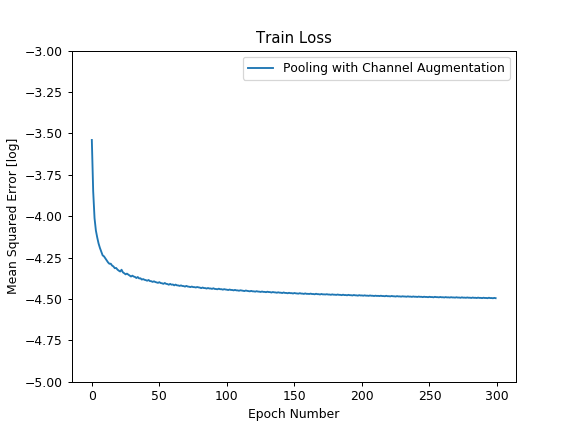

<IPython.core.display.Javascript object>


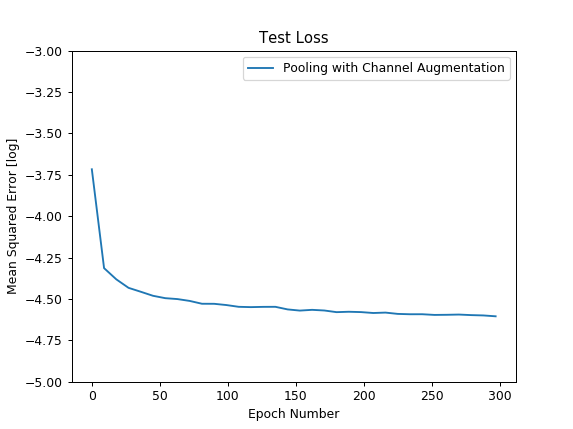

In [18]:
# plot train loss

legend = []
fig = plt.figure()
for result in results:
    
    model_param, model, loss_dict = result
    
    legend = legend + [model_param['legend']]    
    plt.plot(np.log10(loss_dict['train_losses_epoch']))   
   
plt.legend(legend)
plt.title('Train Loss')
plt.ylim([-5, -3])
plt.xlabel('Epoch Number')
plt.ylabel('Mean Squared Error [log]')
plt.show()

plt.savefig('figures/final_report/train_loss.png')

# plot test loss
fig = plt.figure()
for result in results:
    
    model_param, model, loss_dict = result
    plt.plot(np.arange(0, len(loss_dict['test_losses'])) * 9, np.log10(loss_dict['test_losses']))

    
plt.legend(legend)
plt.title('Test Loss')
plt.ylim([-5, -3])
plt.xlabel('Epoch Number')
plt.ylabel('Mean Squared Error [log]')
plt.show()

plt.savefig('figures/final_report/test_loss.png')

In [21]:
# predict test images and calculate ssim
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as compare_mse

def calc_volume_ssim(volume1, volume2):
    volume_ssim = []

    for slice_index in range(volume1.shape[0]):
        img1 = np.squeeze(volume1[slice_index, :, :])
        img2 = np.squeeze(volume2[slice_index, :, :])
        volume_ssim = volume_ssim + [ssim(img1, img2, data_range=1)]
        
    return volume_ssim

def calc_volume_mse(volume1, volume2):
    
    volume_mse = []
    for slice_index in range(volume1.shape[0]):
        img1 = np.squeeze(volume1[slice_index, :, :])
        img2 = np.squeeze(volume2[slice_index, :, :])
        volume_mse = volume_mse + [compare_mse(img1, img2)]
        
    return volume_mse

testing_scans = [5]
results_with_model_output = []

for result in results:
    model_param, model, loss_dict = result
    print(model_param)
    
    generator_test = dd.MRImageSequence(scan_numbers=testing_scans, batch_size=10, augment_channels=model_param['do_channel_augmentation'])    
    
    model_output = model.predict(generator_test.x_transformed[0], batch_size = 10)   
    
    volume_ssim = calc_volume_ssim(model_output, generator_test.y_transformed[0])
    volume_mse = calc_volume_mse(model_output, generator_test.y_transformed[0])
    
    recon_metrics = {}
    recon_metrics['ssim'] = volume_ssim
    recon_metrics['mse'] = volume_mse
    
    results_with_model_output = results_with_model_output + [(model_param, model, loss_dict, model_output, recon_metrics)]
    

{'model_fn': <function get_unet at 0x7f946140cc08>, 'tag': 'pooling_channel_aug_small', 'legend': 'Pooling with Channel Augmentation', 'use_pool': True, 'do_channel_augmentation': True}
('loading scan ', 5)
('X shape: ', (320, 320, 256, 16))
('y shape: ', (320, 320, 256, 1))
('augment_images: ', False)


<IPython.core.display.Javascript object>


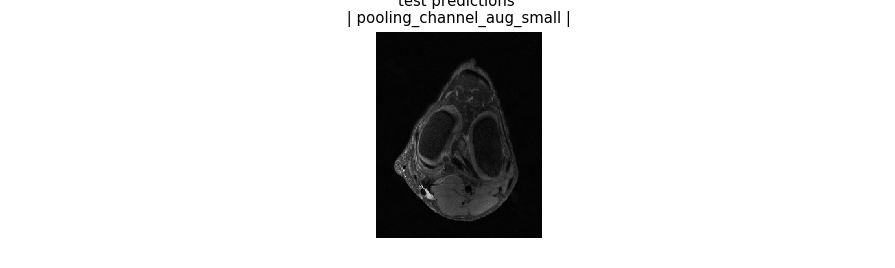

<IPython.core.display.Javascript object>


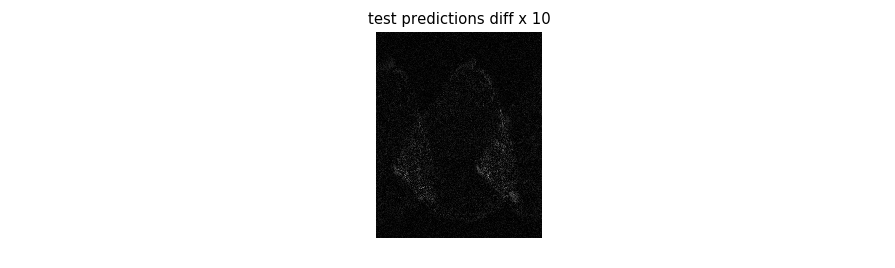

In [22]:
# plot test images
slice_to_show = 190

nx, ny, nz, _ = model_output.shape

compound_image = np.zeros((ny, nz * len(results)))
compound_image_diff = np.zeros((ny, nz * len(results)))
order = '| '

for idx, result in enumerate(results_with_model_output):
    model_param, model, loss_dict, model_output, volume_ssim = result
    
    z_min = idx * nz
    z_max = (idx + 1) * nz
    
    order = order + model_param['tag'] + ' | '
    
    compound_image[:, z_min:z_max] = np.squeeze(model_output[slice_to_show, :, :])
    
    diff = 10 * np.abs(np.squeeze(model_output[slice_to_show, :, :]) - np.squeeze(generator_test.y_transformed[0][slice_to_show, :, :]))
    compound_image_diff[:, z_min:z_max] = np.squeeze(diff)
    
fig = plt.figure(figsize=(10, 3))    
plt.imshow(compound_image, cmap='gray')
plt.title('test predictions \n ' + order)
plt.axis('off')
plt.show()

plt.savefig('figures/final_report/test_predictions_' + str(slice_to_show) + '_volume_' + str(testing_scans[0]) + '.png')

fig = plt.figure(figsize=(10, 3))
plt.imshow(compound_image_diff, cmap='gray', vmin=0, vmax=1)
plt.title('test predictions diff x 10')
plt.axis('off')
plt.show()

plt.savefig('figures/final_report/test_predictions_diff' + str(slice_to_show)  + '_volume_' + str(testing_scans[0]) + '.png')

In [6]:
# 3D slice viewer from https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    
    fig = plt.figure(figsize=(9, 3))    
    ax = plt.gca()    
    ax.volume = volume
    ax.index = volume.shape[0] // 2 # start in middle slice
    ax.imshow(volume[ax.index], cmap='gray', vmin=0, vmax=1)   
    update_ax(ax)    
    plt.axis('off')
    fig.canvas.mpl_connect('key_press_event', process_key)  
    
def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def update_ax(ax):    
    volume = ax.volume
    ax.index = ax.index % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    ax.set_title('Slice: ' + str(ax.index))
    
def previous_slice(ax):
    ax.index = (ax.index - 1)   # wrap around using %
    update_ax(ax)

def next_slice(ax):
    ax.index = (ax.index + 1)
    update_ax(ax)

In [23]:
''' Plot 3d scroller viewer and diff images '''
compound_volume = np.zeros((nx, ny, nz * len(results)))
compound_volume_diff = np.zeros((nx, ny, nz * len(results)))

for idx, result in enumerate(results_with_model_output):
    model_param, model, loss_dict, model_output, volume_ssim = result
    
    z_min = idx * nz
    z_max = (idx + 1) * nz
    
    compound_volume[:, :, z_min:z_max] = np.squeeze(model_output[:, :, :])
    
    diff = 10 * np.abs(np.squeeze(model_output[:, :, :]) - np.squeeze(generator_test.y_transformed[0][:, :, :]))
    compound_volume_diff[:, :, z_min:z_max] = np.squeeze(diff)    

<IPython.core.display.Javascript object>


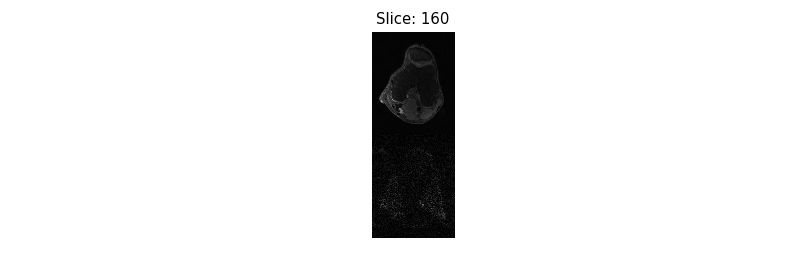

In [24]:
multi_slice_viewer(np.concatenate((compound_volume, compound_volume_diff), axis=1))

<IPython.core.display.Javascript object>


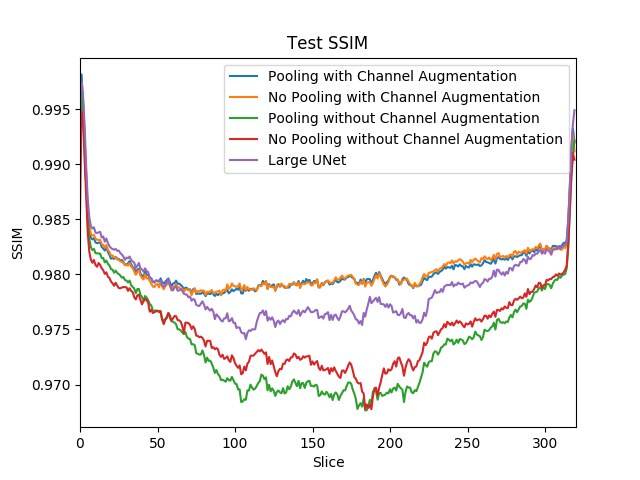

<IPython.core.display.Javascript object>


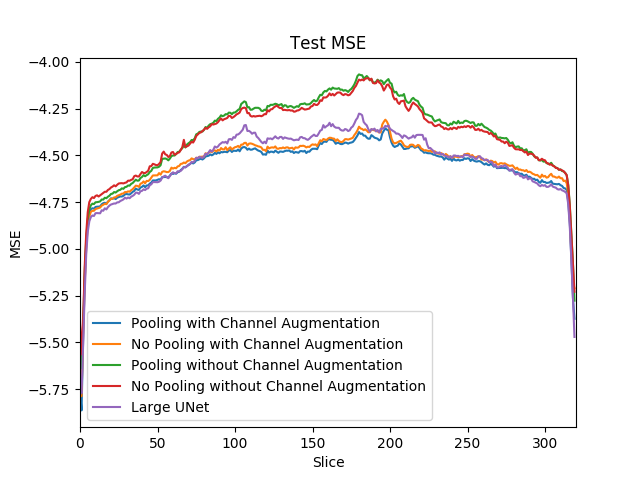

In [10]:
''' Plot ssim '''
legend = []
fig = plt.figure()
for result in results_with_model_output:
    
    model_param, model, loss_dict, model_output, recon_metrics = result
    
    legend = legend + [model_param['legend']]    
    plt.plot(recon_metrics['ssim'])   
   
plt.legend(legend)
plt.title('Test SSIM')
plt.xlim([0,  nx])
plt.xlabel('Slice')
plt.ylabel('SSIM')
plt.show()

plt.savefig('figures/final_report/test_ssim_all_slices_volume_' + str(testing_scans[0]) + '.png')

''' Plot mse '''
fig = plt.figure()
for result in results_with_model_output:
    
    model_param, model, loss_dict, model_output, recon_metrics = result
    
    plt.plot(np.log10(recon_metrics['mse']))
   
plt.legend(legend)
plt.title('Test MSE')
plt.xlim([0,  nx])
plt.xlabel('Slice')
plt.ylabel('MSE')
plt.show()

plt.savefig('figures/final_report/test_mse_all_slices_volume_' + str(testing_scans[0]) + '.png')

In [25]:
'''
# plot the kernel values

for result in results_with_model_output:
    
    model_param, model, loss_dict, model_output, recon_metrics = result
    
    
    
first_layer_weights = model.get_weights()[0]

padding = 2
grid_xx = 4
grid_yy = 8

kernel_img_channels = np.empty((0, 7 * grid_yy))

for kk in range(0, 8, 3): # plot across channels
    
    index = 0
    kernel_img = np.empty((0, 7 * grid_yy))
    for ii in range(grid_xx):

        kernel_img_yy = np.empty((7, 0))
        for jj in range(grid_yy):
            kernel = np.pad(first_layer_weights[:, :, kk, index], pad_width=(padding), mode='constant', constant_values=0)

            kernel_img_yy = np.concatenate((kernel_img_yy, kernel), axis=1)
            index = index + 1        

        kernel_img = np.concatenate((kernel_img, kernel_img_yy), axis=0)
        
    kernel_img_channels = np.concatenate((kernel_img_channels, kernel_img), axis=0)

plt.figure(figsize=(10, 10))
plt.imshow(kernel_img_channels, cmap='gray')
'''

"\n# plot the kernel values\n\nfor result in results_with_model_output:\n    \n    model_param, model, loss_dict, model_output, recon_metrics = result\n    \n    \n    \nfirst_layer_weights = model.get_weights()[0]\n\npadding = 2\ngrid_xx = 4\ngrid_yy = 8\n\nkernel_img_channels = np.empty((0, 7 * grid_yy))\n\nfor kk in range(0, 8, 3): # plot across channels\n    \n    index = 0\n    kernel_img = np.empty((0, 7 * grid_yy))\n    for ii in range(grid_xx):\n\n        kernel_img_yy = np.empty((7, 0))\n        for jj in range(grid_yy):\n            kernel = np.pad(first_layer_weights[:, :, kk, index], pad_width=(padding), mode='constant', constant_values=0)\n\n            kernel_img_yy = np.concatenate((kernel_img_yy, kernel), axis=1)\n            index = index + 1        \n\n        kernel_img = np.concatenate((kernel_img, kernel_img_yy), axis=0)\n        \n    kernel_img_channels = np.concatenate((kernel_img_channels, kernel_img), axis=0)\n\nplt.figure(figsize=(10, 10))\nplt.imshow(kernel_

<class 'tensorflow.python.framework.ops.Tensor'>
((2, 320, 256, 16), dtype('float32'))
('images.shape', (2, 320, 256, 16))


<IPython.core.display.Javascript object>


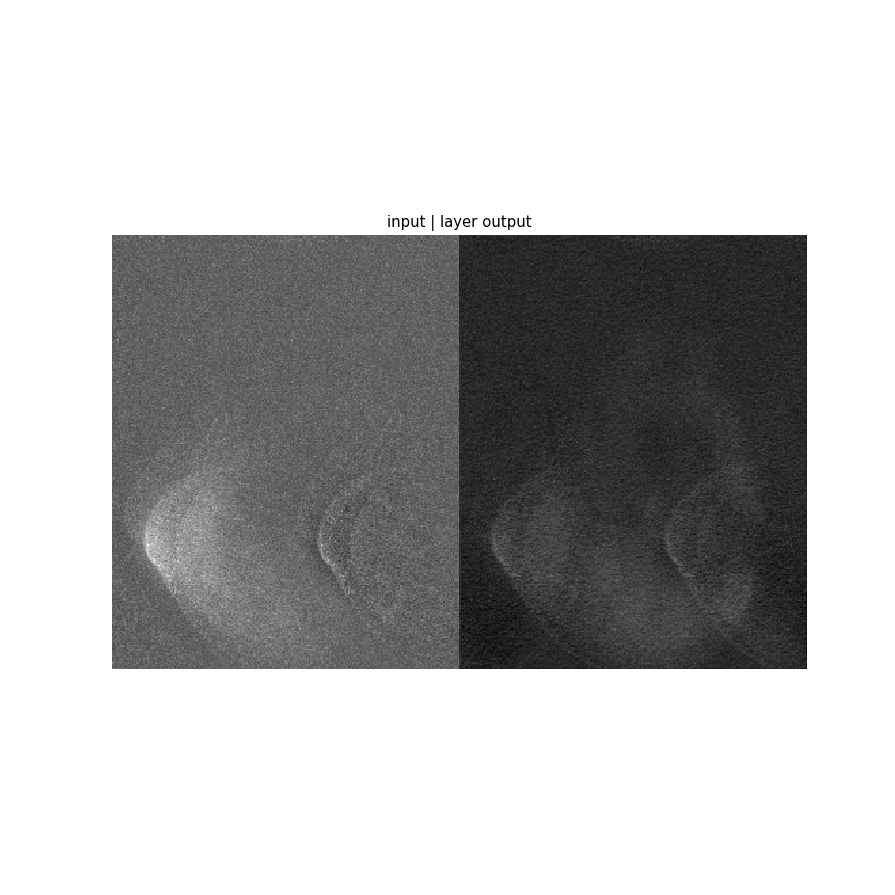

In [38]:
from utils import gen_interm_fun, plot_convs

# tf.keras.backend.set_learning_phase(0)

# Create a function to produce output from intermediate layers
# handles some basic reshaping automatically
input_shape = generator_test.x_transformed[0].shape[1:]
inputs = tf.keras.layers.Input(shape=input_shape)
print(type(model.input))
L1 = gen_interm_fun(model.input, model.layers[1])

# get a couple images
im = generator_test.x_transformed[0][:2, :, :, :]

# evaluate the generated function
# produced shape = NHWC
print(im.shape, im.dtype)
outL1 = L1(im)

# plot the two, can change image number and channel/filter
image_num = 0
input_channel = 0
output_filter = 0

fig = plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((im[image_num, :, :, input_channel], outL1[image_num, :, :, output_filter])), cmap='gray')
plt.title('input | layer output')
plt.axis('off')
plt.show()

In [30]:
inputs

<tf.Tensor 'input_5:0' shape=(?, 320, 256, 8) dtype=float32>

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 320, 256, 8)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 320, 256, 32) 2336        input_3[0][0]                    
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 320, 256, 32) 0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 320, 256, 32) 9248        activation_15[0][0]              
__________________________________________________________________________________________________
activation